In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
#nltk.download('wordnet')
import gensim
import string
from wordcloud import WordCloud
from PIL import Image
import collections

[nltk_data] Downloading package wordnet to /home/quadm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def hasNumber(word):
    return any(char.isdigit() for char in word)
      
def preprocess(textfile):
    with open(textfile, 'r') as reader:
        text = reader.read()
    text = text.lower()     # Make all text lowercase
    nopunct="".join([char for char in text if char not in string.punctuation]) # Remove all punctuation
    tokens = nltk.tokenize.word_tokenize(nopunct) # Tokenize
    nonums = [t for t in tokens if not hasNumber(t)]  # Remove all numbers
    
    ps = PorterStemmer()
    
    nostop = [t for t in nonums if t not in nltk.corpus.stopwords.words('english')]
    return [ps.stem(t) for t in nostop]


In [73]:
import os
from tqdm  import tqdm

data = 'data'
train_corpus = []

for testTrain in ['C50test' , 'C50train']:
    for author in tqdm(os.listdir(os.path.join(data, testTrain))):
        for sample_text in os.listdir(os.path.join(data, testTrain, author)):
            train_corpus.append(preprocess(os.path.join(data, testTrain, author, sample_text)))

100%|██████████| 50/50 [02:17<00:00,  2.76s/it]


In [75]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model = Word2Vec(sentences=train_corpus, size=100, window=5, min_count=1, workers=4)
model.train([tokenized], total_examples=5000, epochs=100)
model.save('articles.model')

/home/quadm/anaconda3/lib/python3.8/site-packages/smart_open/smart_open_lib.py:400: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  warnings.warn(


In [76]:
vocab_list = sorted(list(model.wv.vocab.keys()))
word_vectors = []
for word in vocab_list:
    word_vectors.append(model.wv[word])

word_vectors = np.asarray(word_vectors)

In [77]:
norm_wv = word_vectors / np.linalg.norm(word_vectors)

In [132]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def plotKMeans(n_clusters, data):
    pca = PCA(n_components=2)
    transform = pca.fit_transform(data)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    df = pd.DataFrame(transform)
    df['Labels'] = kmeans.labels_

    for i in range(n_clusters):
        group = df[df['Labels'] == i]
        plt.scatter(group[0], group[1], s=1)
    return df
        
#plotKMeans(1000, norm_wv)

In [82]:
training_data = []
for corp in tqdm(train_corpus):
    n = np.zeros(n_clusters)
    for word in corp:
        i = vocab_list.index(word)
        l = int(df.loc[i]['Labels'])
        n[l] += 1
    training_data.append(n)
        

100%|██████████| 5000/5000 [25:29<00:00,  3.27it/s]


In [277]:
import sklearn
from sklearn.decomposition import TruncatedSVD

X = np.asarray(training_data)
for i in range(len(X)):
    X[i] = X[i] / sum(X[i])

# Perform SVD
svd = TruncatedSVD(n_components=20)
svd.fit(X)
X = svd.transform(X)

#Check explained variance
k = svd.explained_variance_ratio_
s = 0
for i in k:
    s+=i
print(s)
    
y_labels = range(50)
y_labels = list(np.repeat(y_labels, 50))*2
y_labels = np.asarray(y_labels)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y_labels, test_size=0.2)

0.2725790010278422


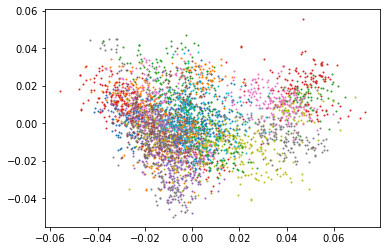

In [278]:
y = plotKMeans(50, X_train)

In [279]:
print(y_train)

[28  6  3 ...  5 35 42]


In [280]:
print(y)

             0         1  Labels
0     0.025275 -0.015406      28
1    -0.013288 -0.018974       5
2    -0.003116 -0.009955      42
3    -0.002961 -0.020081       3
4     0.008220 -0.020517      40
...        ...       ...     ...
3995 -0.032356  0.038103       7
3996  0.012351 -0.003025      39
3997 -0.016250 -0.007581      24
3998 -0.006081 -0.036143      17
3999  0.039803  0.012188       2

[4000 rows x 3 columns]


In [281]:
from sklearn.metrics import normalized_mutual_info_score
y_pred = y['Labels'].values.flatten()
normalized_mutual_info_score(y_pred, y_train)

0.4950321749209997

In [286]:
y_train_labels = {idx: y for idx, y in enumerate(y_train)}
y_train_sorted = {k: v for k, v in sorted(y_train_labels.items(), key=lambda item: item[1])}
y_pred_labels = {idx: y for idx, y in enumerate(y_pred)}
y_pred_sorted = {k: v for k, v in sorted(y_pred_labels.items(), key=lambda item: item[1])}

#Compare two clusters
print(y_pred_labels[1])
print(y_train_labels[1])


5
6


In [287]:
from sklearn.metrics import jaccard_score
c1 = 5
c2 = 6
y_pred_filt = set([k for k, v in y_pred_sorted.items() if v == c1])
y_train_filt = set([k for k, v in y_train_sorted.items() if v == c2])
print(len(y_pred_filt))
print(len(y_train_filt))
print(len(y_pred_filt.intersection(y_train_filt)))



114
81
5


In [284]:
k = np.random.randint(50,size=4000)
j = np.random.randint(50,size=4000)
normalized_mutual_info_score(j,k)

0.08660128828343265